<a href="https://colab.research.google.com/github/22Himanshu/KPMG_-_PwC_article_resarch_automation/blob/main/KPMG_PWC_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langchain-google-genai numpy scikit-learn json matplotlib

ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


Successfully accessed GOOGLE_API_KEY1 from Colab Secrets.
Loaded 207 articles.
Initializing embedding model...
Initialized Google Embedding Model: models/text-embedding-004
Generating embeddings...
Embeddings generated successfully.
Performing Elbow Method to determine optimal k...


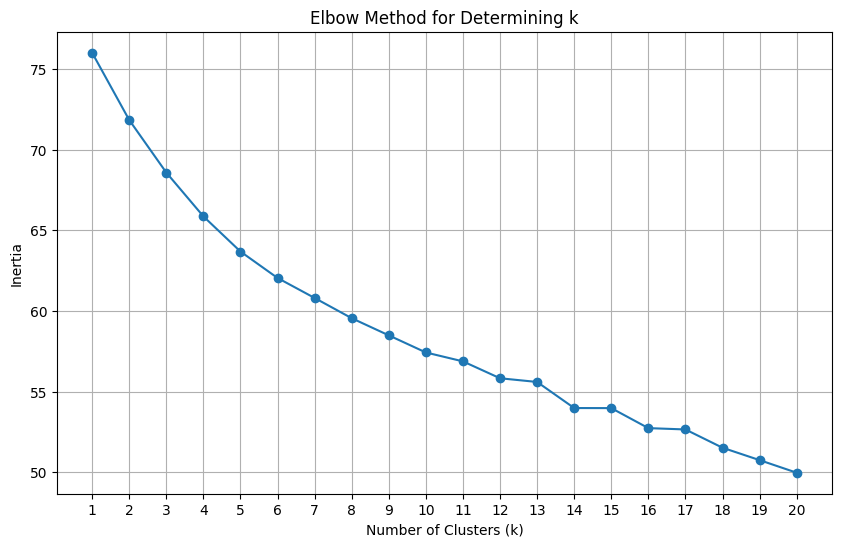

In [2]:
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os # Import the os module to access environment variables
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from google.colab import userdata
GOOGLE_API_KEY_VALUE = userdata.get('GOOGLE_API_KEY1')
# --- Configuration ---
JSON_FILE_PATH = 'extracted_articles.json' # Upload your JSON file to Colab
MAX_K_FOR_ELBOW = 20 # Max number of clusters to test for Elbow Method
EMBEDDING_MODEL_NAME = "models/text-embedding-004"


if not GOOGLE_API_KEY_VALUE:
    print("Error: GOOGLE_API_KEY1 not found in Colab Secrets.")
    exit()
else:
    print("Successfully accessed GOOGLE_API_KEY1 from Colab Secrets.")

articles_data = []
article_contents = []
try:
    with open(JSON_FILE_PATH, 'r', encoding='utf-8') as f:
        articles_data = json.load(f)
        article_contents = [article.get('published_content', '') for article in articles_data]
except FileNotFoundError:
    print(f"Error: File not found at {JSON_FILE_PATH}. Please upload it to your Colab environment.")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {JSON_FILE_PATH}. Check the file format.")
    exit()

if not article_contents:
    print("No content found in the JSON file.")
    exit()

print(f"Loaded {len(articles_data)} articles.")


#Initialize Embedder ---
print("Initializing embedding model...")
try:
    embeddings_model = GoogleGenerativeAIEmbeddings(
        model=EMBEDDING_MODEL_NAME,
        google_api_key=GOOGLE_API_KEY_VALUE
    )
    print(f"Initialized Google Embedding Model: {EMBEDDING_MODEL_NAME}")
except Exception as e:
    print(f"Error initializing embedding model: {e}")
    exit()

print("Generating embeddings...")
try:
    article_embeddings = embeddings_model.embed_documents(article_contents)
    article_embeddings_np = np.array(article_embeddings)
    print("Embeddings generated successfully.")
except Exception as e:
    print(f"Error generating embeddings: {e}")
    exit()

print("Performing Elbow Method to determine optimal k...")
inertia = []
k_range = range(1, min(len(articles_data) if articles_data else 2, MAX_K_FOR_ELBOW) + 1) # Handle empty data case

if len(articles_data) < 2:
    print("Need at least 2 articles to perform clustering.")
else:
    for k in k_range:
        if k == 0: continue
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(article_embeddings_np)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Determining k')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()



In [7]:
# Set FINAL_K based on the plot ---
FINAL_K = 7  # Example value - replace with your chosen k

if FINAL_K > 1 and len(articles_data) >= FINAL_K: # Only cluster if k > 1 and enough data
    print(f"\nApplying KMeans clustering with k = {FINAL_K}")
    final_kmeans = KMeans(n_clusters=FINAL_K, random_state=42, n_init= 10)
    final_kmeans.fit(article_embeddings_np)
    cluster_labels = final_kmeans.labels_
    print("Clustering complete.")

for i, article in enumerate(articles_data):
    article['cluster_id'] = int(cluster_labels[i])


print("\nCalculating average within-cluster similarity...")
similarity_scores_by_cluster = {}

if FINAL_K > 1: # Only calculate if there are multiple clusters
    for cluster_id in range(FINAL_K):
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
        if len(cluster_indices) > 1:
            cluster_embeddings = article_embeddings_np[cluster_indices]
            pairwise_sim = cosine_similarity(cluster_embeddings)
            n = len(cluster_indices)
            sum_sim = np.sum(pairwise_sim)
            # Average of the upper triangle excluding the diagonal
            avg_sim = (sum_sim - n) / (n * (n - 1))

            similarity_scores_by_cluster[cluster_id] = avg_sim
        elif len(cluster_indices) == 1:
             similarity_scores_by_cluster[cluster_id] = 1.0
        else:
             similarity_scores_by_cluster[cluster_id] = 0.0


    # Print within-cluster similarity scores
    print("Average Within-Cluster Similarity Scores:")
    if similarity_scores_by_cluster:
        for cluster_id, avg_sim in similarity_scores_by_cluster.items():
            print(f"  Cluster {cluster_id}: {avg_sim:.4f}")
    else:
        print("  No clusters with more than one article to calculate within-cluster similarity.")
else:
    print("Skipping within-cluster similarity calculation as there is only 1 cluster.")

print("\nArticles with assigned Cluster IDs:")
# Save the results to a new JSON file
output_file_path = 'clustered_articles.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(articles_data, f, indent=4)

print(f"\nClustered articles saved to {output_file_path}")


Applying KMeans clustering with k = 7
Clustering complete.

Calculating average within-cluster similarity...
Average Within-Cluster Similarity Scores:
  Cluster 0: 0.5997
  Cluster 1: 0.6060
  Cluster 2: 0.8698
  Cluster 3: 0.7406
  Cluster 4: 0.7029
  Cluster 5: 0.6869
  Cluster 6: 0.6715

Articles with assigned Cluster IDs:

Clustered articles saved to clustered_articles.json


# Lets check

In [12]:
used_keywords = set()
cluster_themes = {}

for cluster_id, texts in sorted(cluster_texts.items()):  # sort for consistency
    combined_text = [" ".join(texts)]
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = tfidf_scores.argsort()[::-1]  # Sort by importance
    top_keywords = feature_array[top_indices]

    # Filter out already used keywords
    unique_themes = []
    for word in top_keywords:
        if word not in used_keywords:
            unique_themes.append(word)
            used_keywords.add(word)
        if len(unique_themes) == 2:
            break

    cluster_themes[cluster_id] = unique_themes

# Print the updated themes
for cid, themes in cluster_themes.items():
    print(f"Cluster {cid}: Unique Themes = {themes}")


Cluster 0: Unique Themes = ['tax', 'kpmg']
Cluster 1: Unique Themes = ['ai', 'data']
Cluster 2: Unique Themes = ['insights', 'business']
Cluster 3: Unique Themes = ['value', 'risk']
Cluster 4: Unique Themes = ['technology', 'transformation']
Cluster 5: Unique Themes = ['og', 'legal']
Cluster 6: Unique Themes = ['tariffs', 'global']


In [13]:
import random

articles_by_cluster = {}
for article in articles_data:
    cluster_id = article.get('cluster_id') # Use .get() in case cluster_id wasn't added for some reason
    if cluster_id is not None:
        if cluster_id not in articles_by_cluster:
            articles_by_cluster[cluster_id] = []
        articles_by_cluster[cluster_id].append(article)

print("\n--- Sampling 2 Articles from 5 Clusters ---")

cluster_ids_to_sample = range(min(5, len(articles_by_cluster))) # Sample up to 5 clusters if fewer than 5 exist

for cluster_id in cluster_ids_to_sample:
    articles_in_cluster = articles_by_cluster.get(cluster_id, []) # Get list of articles for this cluster ID

    print(f"\nCluster {cluster_id} (contains {len(articles_in_cluster)} articles):")

    if not articles_in_cluster:
        print("  This cluster is empty or does not exist in the sampled range.")
        continue

    # Determine how many articles to sample (min of 3 or the actual size of the cluster)
    num_samples = min(2, len(articles_in_cluster))

    # Randomly sample articles from the cluster
    sampled_articles = random.sample(articles_in_cluster, num_samples)

    # Print information for the sampled articles
    print("  Sampled Articles:")
    for i, article in enumerate(sampled_articles):
        url = article.get('article_url', 'No URL available')
        content = article.get('published_content', 'No content available')
        # Take the first 200 characters of content as a snippet
        content_snippet = content[:200] + '...' if len(content) > 200 else content

        print(f"    Sample {i+1}:")
        print(f"      URL: {url}")
        # Assuming title is not available, printing content snippet instead
        print(f"      Content Snippet: {content_snippet}")
        # If you find where the title is, you would do:
        # title = article.get('your_title_key', 'Title not available')
        # print(f"      Title: {title}")


print("\n--- End Sampling ---")


--- Sampling 2 Articles from 5 Clusters ---

Cluster 0 (contains 26 articles):
  Sampled Articles:
    Sample 1:
      URL: https://kpmg.com/ie/en/home/insights.html
      Content Snippet: Get informed about the big issues on your business agenda
Powering Tomorrow 2025
Energy and Natural Resources
Securing Irelandâs energy future
    Sample 2:
      URL: https://kpmg.com/content/kpmgpublic/kr/en/home/insights/2016/06/ifrs-brief.html
      Content Snippet: For professional IFRS consulting services, IFRS Center of Excellence (COE) team of Samjong KPMG consistently monitors and provides monthly brief summaries of the recent changes in IFRS and the trends ...

Cluster 1 (contains 39 articles):
  Sampled Articles:
    Sample 1:
      URL: https://kpmg.com/ch/en/insights/cybersecurity-risk.html
      Content Snippet: In today's rapidly evolving digital landscape, where technological progress continuously intersects with escalating security vulnerabilities, the imperative for advanced cybe

In [15]:
import plotly.express as px
import pandas as pd

# Prepare DataFrame
umap_df = pd.DataFrame({
    "x": embedding_2d[:, 0],
    "y": embedding_2d[:, 1],
    "Cluster": cluster_labels,
    "Theme": [", ".join(cluster_themes[label]) for label in cluster_labels]
})

# Plot with Plotly
fig = px.scatter(
    umap_df, x="x", y="y",
    color=umap_df["Cluster"].astype(str),
    hover_data={"Cluster": True, "Theme": True, "x": False, "y": False},
    title="Interactive UMAP - KPMG Article Clusters",
    opacity=0.8
)

fig.update_traces(marker=dict(size=8, line=dict(width=0)))
fig.update_layout(
    width=900,
    height=700,
    template="plotly_white",
    legend_title="Cluster",
    title_x=0.5
)
fig.show()
